Como mi ordenador va bastante mal, he preferido utilizar Google Colab para hacer el modelo.

In [36]:
# Acceso a Drive (Google Collab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importar librerías y leer datos

Importamos las librerías que utilizamos en clase, más alguna nueva:

In [ ]:
import pandas as pd
import numpy as np

from datetime import datetime
import requests
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

import re

# IQR/Z score.
from scipy.stats import stats

# Seleción de variables.
from sklearn.feature_selection import SelectKBest

# Modelos Selección.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Modelos.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold

# Preprocesado.
from sklearn import preprocessing

from collections import Counter

from sklearn.datasets import make_classification

from imblearn.over_sampling import ADASYN

import pickle
# Métricas.
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report

In [ ]:
# Lectura de datos
df_train = pd.read_csv('/content/drive/MyDrive/Documentos/MASTER UCM/11. Machine learning - José Ángel Carballo/ENTREGA FINAL/DATA/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
df_target = pd.read_csv('/content/drive/MyDrive/Documentos/MASTER UCM/11. Machine learning - José Ángel Carballo/ENTREGA FINAL/DATA/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Documentos/MASTER UCM/11. Machine learning - José Ángel Carballo/ENTREGA FINAL/DATA/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')

#Depuración de los datos

Vamos a ver las caracteísticas pricipales de los conjuntos de datos para ver cómo podemos mejorar las variables explicativas.

### Juntar train y test para hacer una depuración conjunta

In [ ]:
# Add the 'test' column with 0 value to df_train
df_train = df_train.assign(test=0)

# Add the 'test' column with 1 value to df_test
df_test = df_test.assign(test=1)

In [ ]:
df_mix = pd.concat([df_train, df_test], axis=0)

###Poner id como índice

In [ ]:
df_mix.set_index('id', inplace=True)
df_target.set_index('id', inplace=True)

###Características generales

Vamos a ver cómo son variables (tipo de datos), si hay missings, etc...

In [ ]:
df_mix

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,test
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,Wami / Ruvu,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,1
18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,Pangani,...,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,1
28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,Internal,...,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe,1


In [ ]:
df_mix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 69572 to 68707
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             74250 non-null  float64
 1   date_recorded          74250 non-null  object 
 2   funder                 69746 non-null  object 
 3   gps_height             74250 non-null  int64  
 4   installer              69718 non-null  object 
 5   longitude              74250 non-null  float64
 6   latitude               74250 non-null  float64
 7   wpt_name               74250 non-null  object 
 8   num_private            74250 non-null  int64  
 9   basin                  74250 non-null  object 
 10  subvillage             73780 non-null  object 
 11  region                 74250 non-null  object 
 12  region_code            74250 non-null  int64  
 13  district_code          74250 non-null  int64  
 14  lga                    74250 non-null  object 
 15

In [ ]:
for i in df_mix.columns:
    print(i)
    print(df_mix[i].value_counts())

amount_tsh
0.0         52049
500.0        3874
50.0         3103
1000.0       1858
20.0         1812
            ...  
250000.0        1
350000.0        1
5400.0          1
53.0            1
0.5             1
Name: amount_tsh, Length: 102, dtype: int64
date_recorded
2011-03-17    695
2011-03-15    694
2013-02-03    684
2011-03-16    650
2011-03-14    649
             ... 
2011-09-01      1
2011-09-28      1
2011-09-16      1
2011-09-13      1
2004-01-09      1
Name: date_recorded, Length: 369, dtype: int64
funder
Government Of Tanzania    11299
Danida                     3907
Hesawa                     2782
Rwssp                      1703
World Bank                 1701
                          ...  
Sido                          1
Mosqure                       1
Kkkt Canal                    1
Rc Missionary                 1
Velem                         1
Name: funder, Length: 2140, dtype: int64
gps_height
 0       25649
-16         71
-15         69
-13         68
-19         65
  

Se puede observar como hay 10 variables numéricas y el resto son de tipo object que vamos a definir como categóricas, dentro de estas hay que estudiar con las que tienen muchas categorías diferentes y con las que presentan misings

In [ ]:
#Dividir entre categóricas y numéricas:
num_cols= df_mix.select_dtypes(include=['float64','int64']).columns.to_list()
cat_cols= df_mix.select_dtypes(include=['object']).columns.to_list()

In [ ]:
df_mix[cat_cols].describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,74250,69746,69718,74250,74250,73780,74250,74250,74250,70095,...,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
unique,369,2140,2410,45684,9,21425,21,125,2098,2,...,7,8,6,5,5,10,7,3,7,6
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,695,11299,21751,4440,12871,646,6599,3128,386,63749,...,31712,63505,63505,41522,41522,21216,21216,57286,35628,43239


##Depuración de las variables (una por una)

En esta parte del ejercicio voy a hacer lumpings en una serie de variables del dataset. Podemos definir el lumping como una forma de reducir las categorías de la variable cuando vemos que son demasiadas. Aportamos el número de categorías en las que queremos dejar la variable y a las demás las agrupará en una misma catagoría, la cual se llamará "otros".

###funder

2140 niveles. Añadimos la variable, cambiamos a minúsculas, quitamos espacios y sustituimos los "0", los "notknown" y los registros sin datos por "Desconocido". Hacemos lumping para quedarnos con solo 150 categorías.

In [ ]:
df_mix['funder'] = df_mix['funder'].str.lower()
df_mix['funder'] = df_mix['funder'].str.replace(" ", "")
df_mix['funder'] = df_mix['funder'].replace(["0", "notknown"], "Desconocido", regex=True)
df_mix['funder'] = np.where(df_mix['funder'].str.len() == 0, "Desconocido", df_mix['funder'])

# Hacemos el lumping para quedarnos con 150 categorías
funder_counts = df_mix['funder'].value_counts()
top_150_funders = funder_counts.head(150).index.tolist()
df_mix['funder'] = np.where(~df_mix['funder'].isin(top_150_funders), "Otro", df_mix['funder'])

# Concatenamos 'funder' y 'lga' y aplicamos lumping a la nueva columna
df_mix['fe_fundlga'] = df_mix['funder'] + "_" + df_mix['lga']
fe_fundlga_counts = df_mix['fe_fundlga'].value_counts()
top_150_fe_fundlga = fe_fundlga_counts.head(150).index.tolist()
df_mix['fe_fundlga'] = np.where(~df_mix['fe_fundlga'].isin(top_150_fe_fundlga), "Otro", df_mix['fe_fundlga'])


###lga

125 niveles. Añadimos la variable, cambiamos a minúsculas y quitamos los espacios. Hacemos lumping para quedarnos con 50 categorías.

In [ ]:
df_mix['lga'] = df_mix['lga'].str.lower()
df_mix['lga'] = df_mix['lga'].str.replace(" ", "")

# Hacemos el lumping para quedarnos con 50 categorías
lga_counts = df_mix['lga'].value_counts()
top_50_lga = lga_counts.head(50).index.tolist()
df_mix['lga'] = np.where(~df_mix['lga'].isin(top_50_lga), "Otro", df_mix['lga'])

###Installer

2410 niveles. Añadimos la variable, cambiamos a minúsculas, quitamos espacios y sustituimos los "0" y los "not known" por "Desconocido". Vemos también que en algunos registros no hay datos. Los sustiruimos por "Desconocido". Hacemos lumping para quedarnos con 200 categorías.

In [ ]:
df_mix['installer'] = df_mix['installer'].str.lower()
df_mix['installer'] = np.where(df_mix['installer'].str.len() == 0, "Desconocido", df_mix['installer'])
df_mix['installer'] = df_mix['installer'].replace(["0", "Not known"], "Desconocido", regex=True)
df_mix['installer'] = df_mix['installer'].str.replace(" ", "")

# Hacemos el lumping para quedarnos con 200 categorías
installer_counts = df_mix['installer'].value_counts()
top_200_installers = installer_counts.head(200).index.tolist()
df_mix['installer'] = np.where(~df_mix['installer'].isin(top_200_installers), "Otro", df_mix['installer'])


###scheme_name

Añadimos la variable, cambiamos a minúsculas, quitamos espacios y sustituimos los "0", los "none" y los registros sin datos por "Desconocido". Hacemos lumping para quedarnos con 250 categorías.

In [ ]:
df_mix['scheme_name'] = df_mix['scheme_name'].str.lower()
df_mix['scheme_name'] = np.where(df_mix['scheme_name'].str.len() == 0, "Desconocido", df_mix['scheme_name'])
df_mix['scheme_name'] = df_mix['scheme_name'].replace(["0", "None"], "Desconocido", regex=True)
df_mix['scheme_name'] = df_mix['scheme_name'].str.replace(" ", "")

# Hacemos el lumping para quedarnos con 250 categorías
scheme_name_counts = df_mix['scheme_name'].value_counts()
top_250_scheme_name = scheme_name_counts.head(250).index.tolist()
df_mix['scheme_name'] = np.where(~df_mix['scheme_name'].isin(top_250_scheme_name), "Otro", df_mix['scheme_name'])

###Variable date_recorded

369 niveles. Cambiamos a caracter la variable ya que tenía formato fecha. Me quedo con 250 categorías.

In [ ]:
df_mix['date_recorded'] = df_mix['date_recorded'].str.replace(" ", "")
df_mix['date_recorded'] = df_mix['date_recorded'].astype(str)

# Hacemos el lumping para quedarnos con 250 categorías
date_recorded_counts = df_mix['date_recorded'].value_counts()
top_250_date_recorded = date_recorded_counts.head(250).index.tolist()
df_mix['date_recorded'] = np.where(~df_mix['date_recorded'].isin(top_250_date_recorded), "Otro", df_mix['date_recorded'])

### Variable subvillage



21426 niveles. Añado la variable, cambiamos a minúsculas, quitamos espacios y sustituimos los "0", los "none" y los registros sin datos por "Desconocido". Aplico lumping para quedarnos con 1000 categorías.

In [ ]:
df_mix['subvillage'] = df_mix['subvillage'].str.lower()
df_mix['subvillage'] = df_mix['subvillage'].str.replace(" ", "")
df_mix['subvillage'] = df_mix['subvillage'].replace(["0", "None"], "Desconocido", regex=True)
df_mix['subvillage'] = np.where(df_mix['subvillage'].str.len() == 0, "Desconocido", df_mix['subvillage'])

# Hacemos el lumping para quedarnos con 1000 categorías
subvillage_counts = df_mix['subvillage'].value_counts()
top_1000_subvillage = subvillage_counts.head(1000).index.tolist()
df_mix['subvillage'] = np.where(~df_mix['subvillage'].isin(top_1000_subvillage), "Otro", df_mix['subvillage'])

### Nuevas variables - FE

Antes de separar el modelo en los conjuntos de train y test originales, se crean nuevas variables. *fe_antig* , *fe_code*, una multiplicación entre las variables *region_code* y *district_code*.

In [ ]:
hoy = pd.to_datetime('2013-12-03')

df_mix['fe_code'] = df_mix['region_code'] * df_mix['district_code']
df_mix['date_recorded'] = df_mix['date_recorded'].str.replace(" ", "")
df_mix['date_recorded'] = df_mix['date_recorded'].astype(str)
df_mix['fe_antig'] = (hoy - pd.to_datetime(df_mix['date_recorded'])).dt.days
df_mix['fe_distancia'] = np.sqrt(df_mix['longitude'] ** 2 + df_mix['latitude'] ** 2)

In [ ]:
df_mix['fe_antig']

id
69572     995
8776      272
34310     281
67743     309
19728     874
         ... 
39307    1013
18990     988
28749     274
33492     288
68707     293
Name: fe_antig, Length: 74250, dtype: int64

##Pasar categóricas a numéricas para mejorar el modelo

In [ ]:
# Crear un diccionario para almacenar las transformaciones
label_encoders = {}

for column in cat_cols:
    le = preprocessing.LabelEncoder()
    df_mix[column] = le.fit_transform(df_mix[column])

    # Almacenar el LabelEncoder en el diccionario
    label_encoders[column] = le


#Selección del modelo

Separamos los datos una vez depurados de test y train y juntamos las explicativas con la dependiente:

In [ ]:
# Crear x_train y x_test
df_train = df_mix[df_mix['test'] == 0].copy()
df_test = df_mix[df_mix['test'] == 1].copy()

# Eliminar la columna "test"
df_train = df_train.drop(columns=['test'])
df_test = df_test.drop(columns=['test'])

df_model = df_train.join(df_target, how='inner')

### Muestreo estratificado

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_train, df_target, test_size=0.2, random_state=42, stratify=df_target)

### Primer modelo

He escogido RF porque, aunque no aparezca el código, he utilizado pycaret para ver que algoritmo predice mejor con los datos que tengo.

In [ ]:
model1 = RandomForestClassifier()

In [ ]:
model1.fit(X_train,y_train)
y_pred = model1.predict(X_test)

<ipython-input-21-0967f9e26e6b>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model1.fit(X_train,y_train)


In [ ]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6452
functional needs repair       0.57      0.34      0.43       863
         non functional       0.85      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.74      0.67      0.70     11880
           weighted avg       0.81      0.81      0.81     11880



### Ver variables más importantes

In [ ]:
model1.feature_importances_

array([0.01840317, 0.03511737, 0.02125066, 0.03990181, 0.01865034,
       0.07009188, 0.07121939, 0.0546077 , 0.00089941, 0.00845216,
       0.02068793, 0.01061839, 0.01025475, 0.01107123, 0.01097457,
       0.03027739, 0.02986448, 0.00625098, 0.        , 0.0099279 ,
       0.00957512, 0.00552465, 0.03407302, 0.01567242, 0.01676221,
       0.02353387, 0.01155714, 0.00538912, 0.01616931, 0.01256054,
       0.00732303, 0.00821115, 0.06874671, 0.06069431, 0.01279643,
       0.00948096, 0.00467903, 0.03152853, 0.02840497, 0.01637335,
       0.03571248, 0.07132236, 0.01538777])

<Axes: >

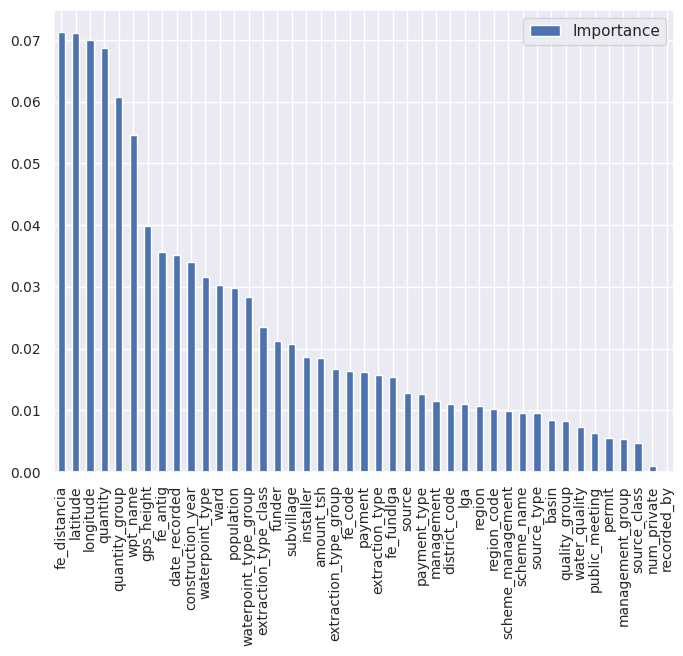

In [ ]:
feat_importances = pd.DataFrame(model1.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

In [ ]:
feat_importances

,Importance
quantity,0.073130
latitude,0.071099
fe_distancia,0.070221
longitude,0.070203
quantity_group,0.059727
wpt_name,0.054200
gps_height,0.040623
fe_antig,0.036010
date_recorded,0.034740
waterpoint_type_group,0.032685


### Tuneo de hiperparámetros

Importante para ver que hiperparámetros optimizan el modelo RF:

In [ ]:
grid_param = {
    'n_estimators': [30, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_depth': [20,22,24]
}



In [ ]:
model_grid = GridSearchCV(estimator=model1,
                     param_grid=grid_param,
                     scoring='f1',
                     cv=5,
                     n_jobs=-1)

In [ ]:
model_grid.fit(X_train, y_train)
print(model_grid.best_params_)
print(model_grid.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'n_estimators': 30}
nan


In [ ]:
model2 = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=20, n_estimators=30).fit(X_train,y_train)
y_pred = model2.predict(X_test)

<ipython-input-25-612322e167c0>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model2 = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=20, n_estimators=30).fit(X_train,y_train)


In [ ]:
model2.predict(X_test)

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [ ]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      6452
functional needs repair       0.58      0.29      0.39       863
         non functional       0.85      0.77      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.74      0.66      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



In [ ]:
results = cross_val_score(estimator=model2, X=X_train, y=y_train, cv=5)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

In [ ]:
results

array([0.80408249, 0.80092593, 0.8069234 , 0.80576599, 0.8035564 ])

In [ ]:
print(results.mean())

0.8042508417508417


In [ ]:
print(results.std())

0.0020495811970641254


## Balanceo de datos

In [ ]:
df_target['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

Vamos a hacer un oversampling para ver si mejoramos la capacidad predictora para ***functional needs repair*** que está infrarrepresentada. Utilizo el algoritmo **ADASYN** que aparece  en la pág web de imbalanced learn:

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html

In [ ]:
print("Before OverSampling, counts of label 'functional':")
print(df_target.value_counts()['functional'])

print("Before OverSampling, counts of label 'functional needs repair':")
print(df_target.value_counts()['functional needs repair'])

print("Before OverSampling, counts of label 'non functional':")
print(df_target.value_counts()['non functional'])


ada = ADASYN(sampling_strategy={'functional': 32259, 'functional needs repair': 8387, 'non functional': 22824},random_state=42)

df_train_res, df_target_res = ada.fit_resample(df_train, df_target)

print('After OverSampling, the shape of train_X: {}'.format(df_train_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(df_target_res.shape))

# Verificar los conteos después del sobremuestreo
print("Before OverSampling, counts of label 'functional':")
print(df_target_res.value_counts()['functional'])

print("Before OverSampling, counts of label 'functional needs repair':")
print(df_target_res.value_counts()['functional needs repair'])

print("Before OverSampling, counts of label 'non functional':")
print(df_target_res.value_counts()['non functional'])

Before OverSampling, counts of label 'functional':
32259
Before OverSampling, counts of label 'functional needs repair':
4317
Before OverSampling, counts of label 'non functional':
22824
After OverSampling, the shape of train_X: (63470, 43)
After OverSampling, the shape of train_y: (63470, 1)
Before OverSampling, counts of label 'functional':
32259
Before OverSampling, counts of label 'functional needs repair':
8387
Before OverSampling, counts of label 'non functional':
22824


In [ ]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(df_train_res,
                                                    df_target_res,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = df_target_res)

In [ ]:
model3 = RandomForestClassifier().fit(X_train_res,y_train_res)
y_pred_res = model3.predict(X_test_res)

<ipython-input-38-06598c1d2798>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model3 = RandomForestClassifier().fit(X_train_res,y_train_res)


In [ ]:
model3.predict(X_test_res)

array(['non functional', 'functional', 'functional', ...,
       'non functional', 'functional', 'functional needs repair'],
      dtype=object)

In [ ]:
print(classification_report(y_test_res, y_pred_res))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6452
functional needs repair       0.79      0.64      0.71      1677
         non functional       0.84      0.79      0.82      4565

               accuracy                           0.82     12694
              macro avg       0.82      0.78      0.79     12694
           weighted avg       0.82      0.82      0.82     12694



Vemos que el modelo mejora al hacer oversampling

### Tuneo de hiperparámetros

In [ ]:
grid_param = {
    'n_estimators': [30, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_depth': [20,22,24]
}



In [ ]:
model_grid = GridSearchCV(estimator=model3,
                     param_grid=grid_param,
                     scoring='f1',
                     cv=5,
                     n_jobs=-1)

In [ ]:
model_grid.fit(X_train_res, y_train_res)
print(model_grid.best_params_)
print(model_grid.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'n_estimators': 30}
nan


In [ ]:
model4 = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=20, n_estimators=30).fit(X_train_res, y_train_res)
y_pred_res = model4.predict(X_test_res)

<ipython-input-45-a40cad6dc281>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model4 = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=20, n_estimators=30).fit(X_train_res, y_train_res)


In [ ]:
y_pred_res

array(['non functional', 'functional', 'functional', ...,
       'non functional', 'functional', 'functional needs repair'],
      dtype=object)

In [ ]:
print(classification_report(y_test_res, y_pred_res))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.82      0.61      0.70      1677
         non functional       0.86      0.77      0.81      4565

               accuracy                           0.82     12694
              macro avg       0.82      0.76      0.79     12694
           weighted avg       0.82      0.82      0.81     12694



In [ ]:
results2 = cross_val_score(estimator=model4, X=X_train_res, y=y_train_res, cv=5)

In [ ]:
results2

array([0.81183537, 0.80393895, 0.80413589, 0.81240768, 0.80925652])

In [ ]:
print(results2.mean())

0.8083148826121466


In [ ]:
print(results2.std())

0.0036508703818201238


De acuerdo a la validación cruzada el modelo4 es el que mejores resultados tiene 🤔

###Modelo final aprovechando todos los datos

Coger los datos de entrenamiento totales y no la partición:

In [ ]:
model5 = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=20, n_estimators=30).fit(df_train_res, df_target_res)

<ipython-input-22-3d239e26259a>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model5 = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=20, n_estimators=30).fit(df_train_res, df_target_res)


#Crear las predicciones y subir un csv. a la plataforma

In [ ]:
# Hacer predicciones en el conjunto de prueba (x_test)
predicciones = model5.predict(df_test)

In [ ]:
# Reiniciar el índice para que el ID sea una columna
df_test.reset_index(inplace=True)

In [ ]:
# Crear un DataFrame con las columnas 'id' y 'predicción'
df_predicciones = pd.DataFrame({'id': df_test['id'], 'status_group': predicciones})

# Guardar las predicciones en un archivo CSV
df_predicciones.to_csv('/content/drive/MyDrive/Documentos/MASTER UCM/11. Machine learning - José Ángel Carballo/ENTREGA FINAL/predicciones.csv', index=False)

In [ ]:
df_predicciones

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


###Nota

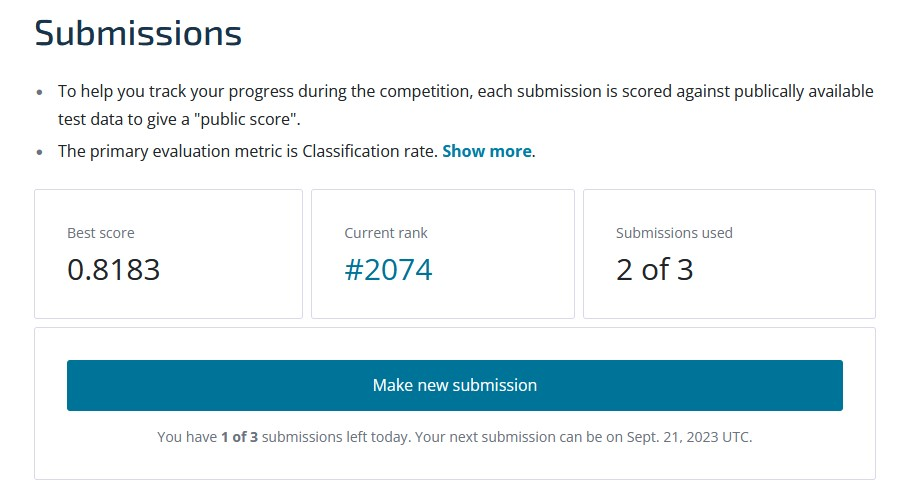